In [141]:
#!pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
#!pip install layoutparser[ocr]
#!pip install pytesseract

# Also install: 
#!sudo apt install -y libtesseract-dev
#!sudo apt install -y tesseract-ocr

In [142]:
import requests
import layoutparser as lp
import cv2
from pycocotools.coco import COCO

In [143]:
# Split annotations data into training and test
#python cocosplit.py --annotation-path ./data/bib/result.json --split-ratio 0.85 --train               ../data/bib/train.json --test ../data/bib/test.json
# Training command
#python train_net.py --dataset_name sample_graphs --json_annotation_train sample_graphs/train.json --image_path_train sample_graphs/ --json_annotation_val sample_graphs/test.json --image_path_val sample_graphs/ --config-file fast_rcnn_R_50_FPN_3x.yaml OUTPUT_DIR . SOLVER.IMS_PER_BATCH 2 SOLVER.MAX_ITER = 1300

## Load the model file and set the elements

In [144]:
model = lp.Detectron2LayoutModel(
    config_path = "config.yaml",
    model_path = "model_final.pth",
    extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                   label_map={0: "chart_title", 1:"axis_title", 2:"tick_label", 3:"plot-bb",4:"x-axis-tick", 5:"y-axis-tick", 6:"other", 7:"tick_grouping"} # <-- Only output high accuracy preds
)

In [145]:
#image = cv2.imread("../data/train/images/45c20af1f6b8.jpg")
image = cv2.imread("../data/test/images/007a18eb4e09.jpg")
image = image[..., ::-1]

### Plot image with the predicted element boxes

/usr/local/lib/python3.9/dist-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


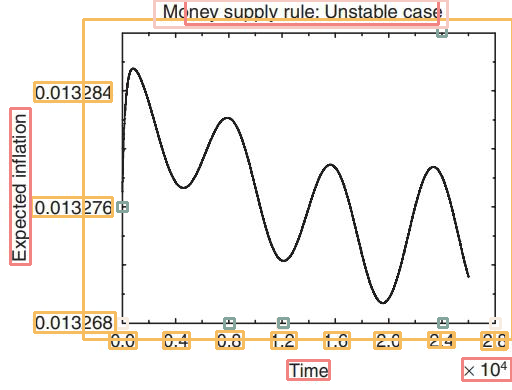

In [146]:
layout = model.detect(image)
lp.draw_box(image, layout, box_width=3)

In [147]:
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=83.58659362792969, y_1=19.001148223876953, x_2=512.0, y_2=339.81005859375), text=None, id=None, type=plot-bb, parent=None, next=None, score=0.9999285936355591), TextBlock(block=Rectangle(x_1=109.52410888671875, y_1=332.4011535644531, x_2=136.0870819091797, y_2=348.6235046386719), text=None, id=None, type=tick_label, parent=None, next=None, score=0.9879248142242432), TextBlock(block=Rectangle(x_1=163.1214599609375, y_1=332.29058837890625, x_2=189.50341796875, y_2=348.1521911621094), text=None, id=None, type=tick_label, parent=None, next=None, score=0.9862905144691467), TextBlock(block=Rectangle(x_1=216.4418182373047, y_1=331.8377380371094, x_2=243.3680877685547, y_2=348.44561767578125), text=None, id=None, type=tick_label, parent=None, next=None, score=0.9856029748916626), TextBlock(block=Rectangle(x_1=374.8288269042969, y_1=332.3216857910156, x_2=400.55902099609375, y_2=348.542724609375), text=None, id=None, type=tick_label, parent=None, ne

In [148]:
# Function to plot the various elements
def plot_elements(element_name: str, layout, image):
    element_blocks = lp.Layout([b for b in layout if b.type==element_name])
    
    h, w = image.shape[:2]

    left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

    left_blocks = element_blocks.filter_by(left_interval, center=True)
    left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

    right_blocks = [b for b in element_blocks if b not in left_blocks]
    right_blocks.sort(key = lambda b:b.coordinates[1])

    # And finally combine the two list and add the index
    # according to the order
    element_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])
    
    return element_blocks

In [149]:
# Extract OCR
ocr_agent = lp.TesseractAgent(languages='eng')

def get_ocr_text(element_blocks, image, left=5, right=5, top=5, bottom=5):
    for block in element_blocks:
        segment_image = (block
                       .pad(left, right, top, bottom)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)
    
    for txt in element_blocks.get_texts():
        print(txt, end='\n---\n')


## Plot the bounding box element and extract text
If we pad the element to be large enough then all the elements of the graph are extracted here - the title, the x 
and y-axis lables, axis titles etc.

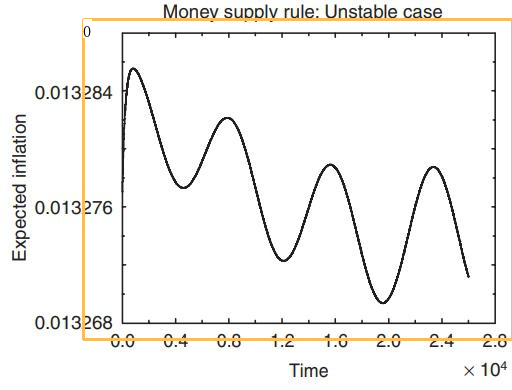

In [150]:
element_blocks = plot_elements('plot-bb', layout, image)
lp.draw_box(image, element_blocks,box_width=3, show_element_id=True)

In [151]:
get_ocr_text(element_blocks, image, left=15, right=15, top=15, bottom=15)

3284

3276

3268
0.0

Money supply rule: Unstable case

0.4

08

1.6

2.0

24

 

28

---


## Extract chart title

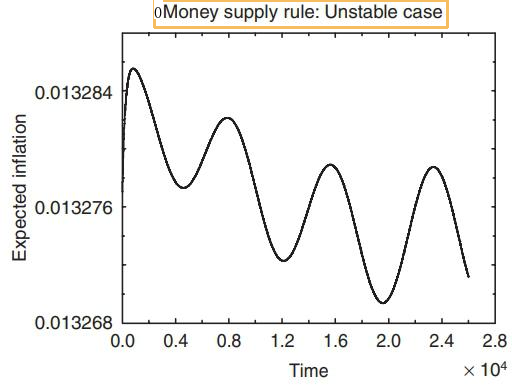

In [152]:
element_blocks = plot_elements('chart_title', layout, image)
lp.draw_box(image, element_blocks,box_width=3, show_element_id=True)


In [153]:
get_ocr_text(element_blocks, image)

Money supply rule: Unstable case

---


## Extract tick labels
Tick lables are generally being identified with high precision but the Tesseract OCR agent is having trouble
extracting them individually. We probably need to train longer, pad the elements or use the Google Cloud Vision OCR agent.

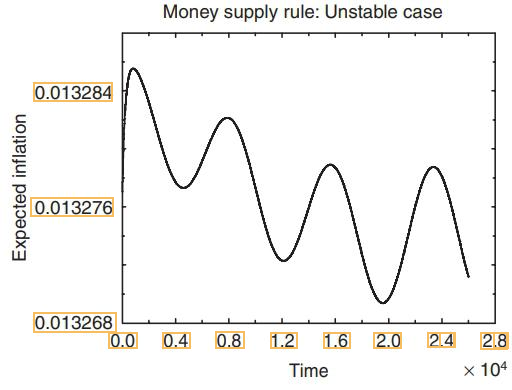

In [154]:
element_blocks_tick_labels = plot_elements('tick_label', layout, image)
lp.draw_box(image, element_blocks_tick_labels,box_width=2, show_element_id=False)

In [155]:
get_ocr_text(element_blocks_tick_labels, image, left=5, right=5, top = 5, bottom=5)

None
---
None
---
None
---
None
---
None
---
None
---
None
---
None
---
None
---
None
---
None
---
None
---

---


## Extract Axis titles

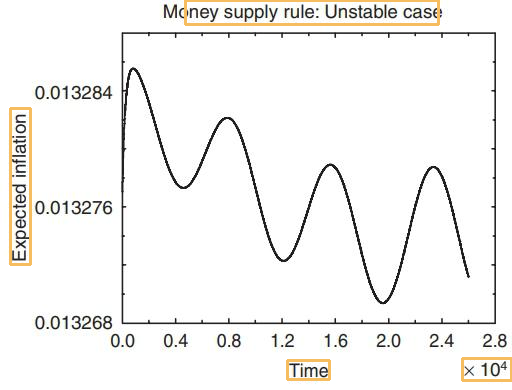

In [156]:
element_blocks = plot_elements('axis_title', layout, image)
lp.draw_box(image, element_blocks,box_width=3, show_element_id=False)

Here the y-axis title (which is rotated 90 degrees) is not extracted easily but the x-axis title is extracted
correctly.

In [157]:
get_ocr_text(element_blocks, image)

None
---
None
---
None
---
Time

---


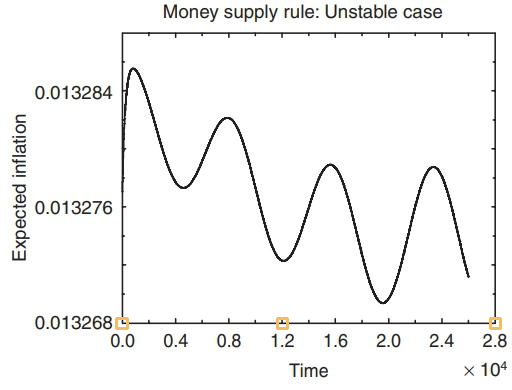

In [158]:
element_blocks = plot_elements('x-axis-tick', layout, image)
lp.draw_box(image, element_blocks,box_width=3, show_element_id=False)

In [159]:
get_ocr_text(element_blocks, image)

None
---
None
---

---


In [ ]:
element_blocks = plot_elements('y-axis-tick', layout, image)
lp.draw_box(image, element_blocks,box_width=3, show_element_id=False)

In [ ]:
get_ocr_text(element_blocks, image)